In [132]:
import numpy as np
import pandas as pd
import random
import mir_utils as miru
import sounddevice as sd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from sklearn.metrics import classification_report, confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from ast import literal_eval
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
import warnings
#confusion cell
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')

#free style version in openset CNN at bottom
def fitModel(encoding_path,dvn=False):
    testFraction=0.2
    #load same data as t-SNE but train SVM(or something else) with it    
    df=pd.read_csv(encoding_path)
    
    if dvn:
        label_groups="label" #do drum vs not drum
    else:
        
        label_groups="drum_type" #do drum vs drum vs notdrum
        

#     df=df.loc[df["drum_type"].isin(["other","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


    #preperocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[label_groups])
    le.transform(df[label_groups])
    df[label_groups]=le.transform(df[label_groups])
    y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


    #calculating weights
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}
    y=df[label_groups]

    df["feats"]=df["feats"].apply(literal_eval)
    #df[feats] is an array of lists, needs conversion to ndArray
    X=np.array([np.array(x) for x in df["feats"].to_numpy()])
    wdict=y_counts.to_dict()
    total = sum(wdict.values(), 0.0)
    class_weights = {k: (total-v) / total for k, v in wdict.items()}


    classifier = make_pipeline(StandardScaler(), SVC(gamma=0.001,C= 100,kernel='rbf',class_weight=class_weights))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    print(cross_val_score(classifier, X, y, cv=cv))
    classifier.fit(X_train, y_train,)
    y_pred = classifier.predict(X_test)


    return classifier, X_train, X_test, y_train, y_test,y_pred,le,X,y,class_weights,


p2="csvs/dk1x5_best_embenv.csv"

# classifier, X1_train, X1_test, y1_train, y1_test,y1_pred,le1,X1,y1,class_weights  = fitModel(p1)
# print(confusion_matrix(y1_test,y1_pred))
# print(classification_report(le1.inverse_transform(y1_test),le1.inverse_transform(y1_pred)))

classifier, X2_train, X2_test, y2_train, y2_test,y2_pred,le2,X2,y2,class_weights = fitModel(p2)

print(confusion_matrix(y2_test,y2_pred))
print(classification_report(le2.inverse_transform(y2_test),le2.inverse_transform(y2_pred)))

[0.91740788 0.9180432  0.91645489 0.9180432  0.91836086]
[[  67    1    0    0   10    1    1]
 [   0   93    0    0    9    2    4]
 [   3    1    4    0   12    0    0]
 [  23    0    0    2    0    1    0]
 [   8   15    1    0  142    0    7]
 [   5   11    1    0    4 1585    2]
 [   0   33    0    0   11    0   40]]
              precision    recall  f1-score   support

         hat       0.63      0.84      0.72        80
        kick       0.60      0.86      0.71       108
         rim       0.67      0.20      0.31        20
       shake       1.00      0.08      0.14        26
       snare       0.76      0.82      0.79       173
 synth_noise       1.00      0.99      0.99      1608
         tom       0.74      0.48      0.58        84

    accuracy                           0.92      2099
   macro avg       0.77      0.61      0.61      2099
weighted avg       0.93      0.92      0.92      2099



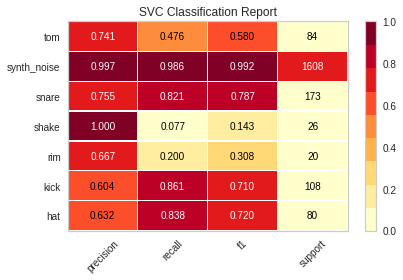

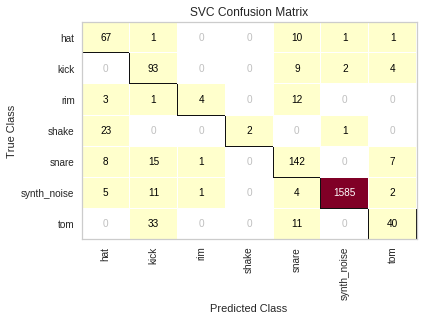

In [133]:
visualizer = ClassificationReport(classifier,classes=le2.classes_, support=True)

visualizer.fit(X2_train, y2_train)  # Fit the visualizer and the model
visualizer.score(X2_test, y2_test)  # Evaluate the model on the test data
visualizer.poof()

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(classifier, classes=le2.classes_)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X2_train, y2_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.

cm.score(X2_test, y2_test)

# How did we do?
cm.show()


In [108]:
models = [
    SVC(gamma=0.001,C= 100,kernel='rbf',class_weight=class_weights), LinearSVC(C=10,class_weight=class_weights), 
    KNeighborsClassifier(n_neighbors=30,),
    RandomForestClassifier(n_estimators=300,class_weight=class_weights), ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights),
]
# models = [
#     SVC(gamma=0.0001,C= 1000,kernel='rbf',class_weight=class_weights), LinearSVC(C=10,class_weight=class_weights), 
#     KNeighborsClassifier(n_neighbors=5,),
#     RandomForestClassifier(n_estimators=400,class_weight=class_weights), ExtraTreesClassifier(n_estimators=1000,class_weight=class_weights)]#dvn
  


# tuning cell

In [56]:

from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Split the dataset in two equal parts
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
# tuned_parameters = [{
#                      'n_neighbors': [2,5,10,20,30]},
#                     ]
tuned_parameters = [{
                     'n_estimators': [1100,1300,800,400,300]},
                    ]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000,1500,2000,]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


scores = ['f1','jaccard']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
         RandomForestClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train,)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'n_estimators': 400}

Grid scores on development set:

0.866 (+/-0.021) for {'n_estimators': 1100}
0.865 (+/-0.017) for {'n_estimators': 1300}
0.864 (+/-0.023) for {'n_estimators': 800}
0.866 (+/-0.024) for {'n_estimators': 400}
0.865 (+/-0.017) for {'n_estimators': 300}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       123
           1       0.80      0.87      0.83       243
           2       0.77      0.76      0.77       241
           3       0.99      0.99      0.99       962

    accuracy                           0.92      1569
   macro avg       0.86      0.84      0.85      1569
weighted avg       0.92      0.92      0.92      1569


# Tuning hyper-parameters for jaccard

Best parameters set found on devel

In [109]:
import plotly.graph_objects as go
import plotly
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
colors1=plotly.colors.sequential.Tealgrn[2:]
colors2=plotly.colors.sequential.Tealgrn_r[2:]
scope = PlotlyScope()
fig = go.Figure()

df=pd.DataFrame(columns=["model","feat_type","y"])

for i,model in enumerate(models):
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # for quick test
    name=type(model).__name__.split("Class")[0]
    for y in cross_val_score(model, X2, y2, cv=cv):

        df.loc[len(df)]=[name,"Embedding+Envelope",y]   

df=df[::-1] #legend gets in the way
df.to_csv("csvs/r2_dvn_comparisons.csv")



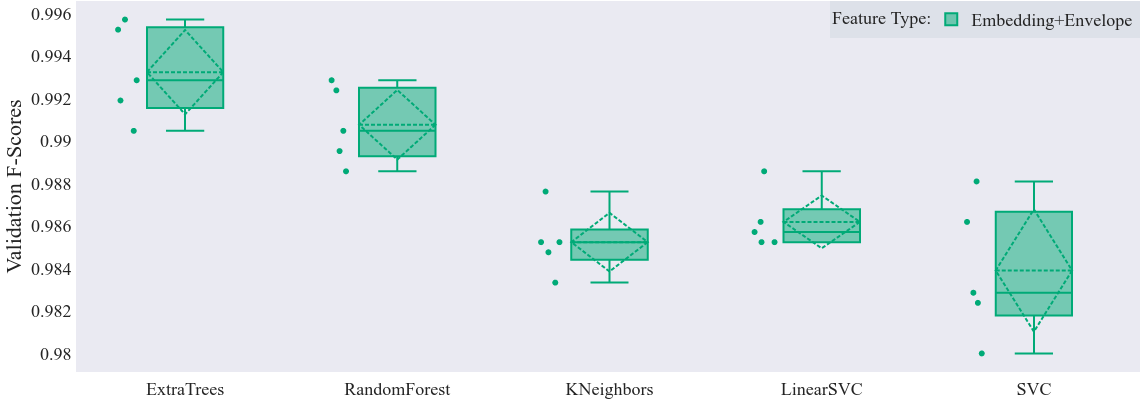

In [111]:
comparison_csv_file="csvs/r2_dvn_comparisons.csv"
df=pd.read_csv(comparison_csv_file)
fig = px.box(df, x="model", y="y", color="feat_type",
             color_discrete_sequence=["#00AA77","#3388BB"],
             title="Box plot of total bill",
            )
fig.update_layout(
#     showlegend=False,
    
    autosize=False,title=None, 
    template="seaborn",
    width=900,height=400,
    font_family="Times New Roman",
    font_size=18,
    title_font_family="Times New Roman",
    title_font_size=30,
    boxmode='group',
    margin=dict(l=0, t=1,r=5, b=3),       
    boxgap=0.4,boxgroupgap=0.4,
        legend_title_text="Feature Type:",
                  legend=dict(
                      bgcolor='rgba(110,150,160,0.1)',
                  orientation="h",
                yanchor="top",
                y=1,
                xanchor="right",x=1)
    )
fig.update_traces(
        boxmean="sd", # represent mean. (sd shows standarddev)
        boxpoints='all', 
)
fig.update_xaxes(showgrid=False,zeroline=False,ticks='',title=None)
fig.update_yaxes(showgrid=False,zeroline=False,title="Validation F-Scores")

fig.show()
# df.to_csv("comparison_csv_file")
with open("../plots/r2_comparisons_mme.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf", width=900,height=400,))

In [137]:
#free style version in openset CNN at bottom

# encoding_path="csvs/radarfree_best_embenv.csv" #good
encoding_path="csvs/dk1x5_best_embenv.csv" #good

# experiment="dvn"
experiment="dvd"

    
if experiment=="dvn":
    label_groups="label" #do drum vs not drum
else:
    label_groups="drum_type" #do drum vs drum vs notdrum

testFraction=0.25
#load same data as t-SNE but train SVM with it    

df=pd.read_csv(encoding_path)
# df=df.loc[df["drum_type"].isin(["clap","hat","kick","snare","synth_noise"])]  
#     print(df.groupby([label_groups]).agg("count")["path"])#sample counts


#preperocessing
le = preprocessing.LabelEncoder()
le.fit(df[label_groups])
le.transform(df[label_groups])
df[label_groups]=le.transform(df[label_groups])
y_counts=df.groupby([label_groups]).agg("count")["path"] #for weights


#calculating weights
wdict=y_counts.to_dict()
total = sum(wdict.values(), 0.0)
class_weights = {k: (total-v) / total for k, v in wdict.items()}
y=df[label_groups]

df["feats"]=df["feats"].apply(literal_eval)
#df[feats] is an array of lists, needs conversion to ndArray
X=np.array([np.array(x) for x in df["feats"].to_numpy()])
wdict=y_counts.to_dict()
total = sum(wdict.values(), 0.0)
class_weights = {k: (total-v) / total for k, v in wdict.items()}


# clf = load('../feature_extraction/models/mme/mme_svm2.joblib') 
classifier = make_pipeline(StandardScaler(),ExtraTreesClassifier(n_estimators=1100,class_weight=class_weights))
# classifier = make_pipeline(StandardScaler(), SVC(gamma=0.001,C= 100,kernel='rbf',class_weight=class_weights))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testFraction, random_state=42,)
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# print(cross_val_score(classifier, X, y, cv=cv))
classifier.fit(X_train, y_train,)
y_pred = classifier.predict(X_test)

In [138]:
from joblib import dump, load
dump(classifier, 'models/mme/r2_mme.joblib') 

le.classes_

array(['hat', 'kick', 'rim', 'shake', 'snare', 'synth_noise', 'tom'],
      dtype=object)

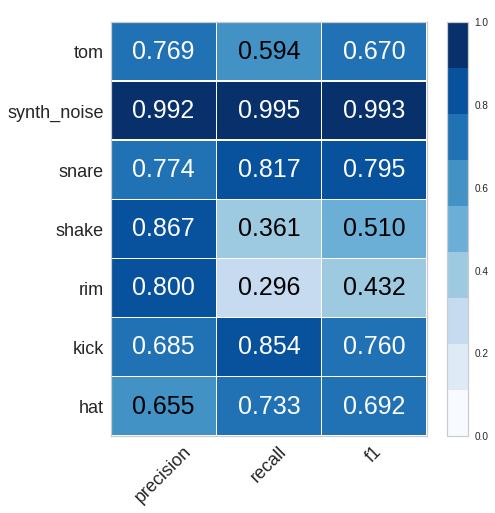

In [139]:

if experiment == "dvn":
    le.classes_=["Drum","Not Drum"]
visualizer = ClassificationReport(classifier,classes=le.classes_,cmap="Blues",fontsize=30, title=" ",size=(500,500))
visualizer.score(X_test, y_test) 
visualizer.finalize()
for label in visualizer.ax.texts:
    label.set_size(25)
# Get access to the axes object and modify labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# plt.tight_layout()
plt.tight_layout(pad=0.05)
plt.savefig("../plots/r2_f1_mme_%s.pdf"%experiment)

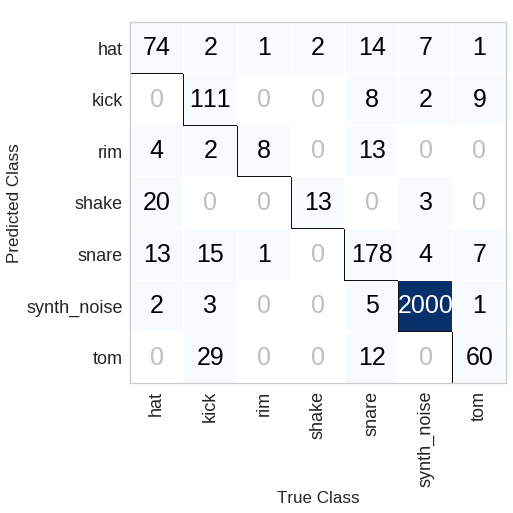

In [146]:

cm = ConfusionMatrix(classifier, classes=le.classes_,cmap="Blues",percent=False,fontsize=30,title=" ",size=(500,500))

cm.score(X_test, y_test)
cm.finalize()
for label in cm.ax.texts:
    label.set_size(25)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Get access to the axes object and modify labels
# plt.suptitle('2014 Sales Analysis', fontsize=14, fontweight='bold');
plt.xlabel('True Class', fontsize=17)
plt.ylabel('Predicted Class', fontsize=17)
plt.tight_layout(pad=0.05)
plt.savefig("../plots/r2_conf_mapping_justification_%s.pdf"%experiment)